In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Gadget_pack.units as unt
import pandas as pd

In [2]:
acc_data = !ls ../acc_duomenys/
acc_data=acc_data[1:]
acc_data;

In [3]:
f = open('../acc_duomenys/acc_data_help.txt','r')
for line in f:
    print(line.strip())
f.close()

fulldata[0,:] = time_list # codeunits
fulldata[1,:] = mtot # g
fulldata[2,:] = dm_dt # g/s
fulldata[3,:] = Etot # erg
fulldata[4,:] = Ld # erg/s
fulldata[5,:] = Ld/Le # Eddingtons units


In [4]:
#laikas istikro kazkodel sekundem o ne kodo vienetais
t = np.loadtxt("../acc_duomenys/" + acc_data[0])[0,:]
t / unt.yr_in_s;# * unt.UnitTime_in_s / unt.yr_in_s
t = np.array(t)

In [5]:

def get_total_mass(acc_data):
    mtot = np.zeros(len(acc_data))
    for i in range(len(acc_data)):
        m = np.loadtxt("../acc_duomenys/"+acc_data[i])
        mtot[i] = m[1,-1]
    return mtot
    

In [6]:
mt = get_total_mass(acc_data)
#mtang = mt.copy().reshape(12,4)
angle = np.arange(0,181,15)
#anglesn = (np.ones(4)[np.newaxis,:]*angle[angle!=165, np.newaxis]).T

In [7]:
mtang = np.load("total_acc_mass.npy")

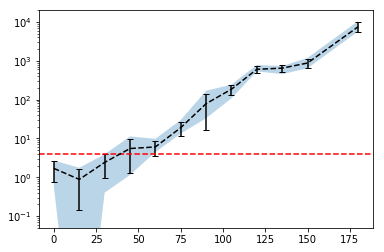

In [8]:
A = mtang.std(axis=1, ddof=1)
B = mtang.mean(axis=1)
plt.errorbar(angle[angle!=165], B / unt.M_s, yerr=A / unt.M_s, color='k',\
             linestyle='--',capsize=3)
plt.yscale('log')
#plt.plot(anglesn, mtang / unt.M_s)
plt.ylim(0.5e-1, 2e4)

MAX = mtang.max(axis=1)
MIN = mtang.min(axis=1)
plt.fill_between(angle[angle!=165], MIN / unt.M_s, MAX / unt.M_s, alpha=0.3)
plt.axhline(y=4, linestyle='--',color='r')
#plt.xlim(r'$\gamma$')
#plt.ylim(r'M$_s$')

In [9]:
data = pd.DataFrame(mtang, index=angle[angle!=165])
data

,0,1,2,3
0,1.117025e+33,4.103706e+33,2.870526e+33,5.384224e+33
15,2.220646e+27,3.507802e+33,1.358091e+33,2.156078e+33
30,7.987852e+32,5.355981e+33,5.309040e+33,7.769035e+33
45,2.280192e+33,2.247411e+34,1.078754e+34,8.334707e+33
60,8.860598e+33,9.792246e+33,1.954511e+34,9.972449e+33
75,3.046671e+34,5.958845e+34,3.416147e+34,2.663709e+34
90,3.377246e+35,8.654457e+34,1.370994e+35,6.592143e+34
105,4.133727e+35,4.874466e+35,3.647428e+35,2.156092e+35
120,1.087150e+36,1.065461e+36,1.558993e+36,1.106081e+36
135,1.459556e+36,1.398241e+36,1.401003e+36,9.051502e+35


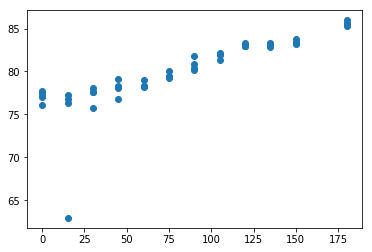

In [10]:
plt.scatter((np.ones(4)[:,np.newaxis]*angle[angle!=165]).T, np.log(mtang))


In [11]:
y_new =  mt.copy()
y_new
x_new = angle[angle!=165]
p = (x_new*np.ones(4)[:,np.newaxis]).T
p

array([[  0.,   0.,   0.,   0.],
       [ 15.,  15.,  15.,  15.],
       [ 30.,  30.,  30.,  30.],
       [ 45.,  45.,  45.,  45.],
       [ 60.,  60.,  60.,  60.],
       [ 75.,  75.,  75.,  75.],
       [ 90.,  90.,  90.,  90.],
       [105., 105., 105., 105.],
       [120., 120., 120., 120.],
       [135., 135., 135., 135.],
       [150., 150., 150., 150.],
       [180., 180., 180., 180.]])

In [12]:
x_new = p.reshape(len(y_new))
y_new = np.log(y_new)

print(x_new.shape)
print(y_new.shape)
paklaida = (mtang.std(axis=1)*np.ones(4)[:,np.newaxis]).T.reshape(np.size(mtang))
print(paklaida.shape)
#plt.scatter(x_new, np.log(y_new))
x_new = x_new[8:]
y_new = y_new[8:]
paklaida = paklaida[8:]

(48,)
(48,)
(48,)


(40, 2)
(40, 40)


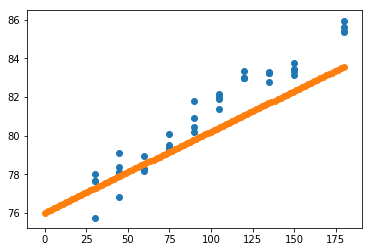

In [13]:
A = np.vstack((np.ones_like(x_new), x_new)).T
C = (paklaida * paklaida)*np.eye(len(paklaida), len(paklaida))
print(A.shape)
print(C.shape)

cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_new)))


xs = np.linspace(0,180,100)
ys = m_ls*xs + b_ls
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)

In [14]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [15]:
import scipy.optimize as op
f_true = 0.5
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls, np.log(f_true)], args=(x_new, y_new, paklaida))
m_ml, b_ml, lnf_ml = result["x"]

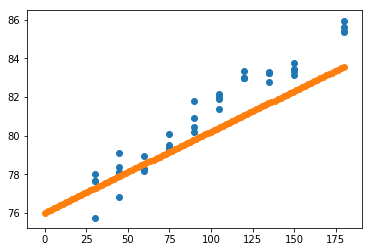

In [16]:
xs = np.linspace(0,180,100)
ys = m_ml*xs + b_ml
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)

In [17]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [18]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [19]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [20]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_new, y_new, paklaida))

In [21]:
sampler.run_mcmc(pos, 500)

/home/s_matas/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/s_matas/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ 4.19585989e-02,  7.60216769e+01, -6.93048489e-01],
        [ 4.19218930e-02,  7.60218559e+01, -6.92992822e-01],
        [ 4.18678123e-02,  7.60219348e+01, -6.93206536e-01],
        [ 4.20821764e-02,  7.60217493e+01, -6.93265165e-01],
        [ 4.20867482e-02,  7.60218086e+01, -6.93175799e-01],
        [ 4.17411611e-02,  7.60218135e+01, -6.93155745e-01],
        [ 4.18568872e-02,  7.60219864e+01, -6.93254005e-01],
        [ 4.18589738e-02,  7.60217307e+01, -6.93246768e-01],
        [ 4.18325247e-02,  7.60217169e+01, -6.93244659e-01],
        [ 4.18407709e-02,  7.60217832e+01, -6.93084110e-01],
        [ 4.18348667e-02,  7.60218263e+01, -6.93039699e-01],
        [ 4.19847946e-02,  7.60217639e+01, -6.93281387e-01],
        [ 4.18627598e-02,  7.60215856e+01, -6.93334138e-01],
        [ 4.17847314e-02,  7.60217725e+01, -6.93295128e-01],
        [ 4.19211020e-02,  7.60218236e+01, -6.93092682e-01],
        [ 4.20261068e-02,  7.60217015e+01, -6.93204035e-01],
        [ 4.17204213e-02

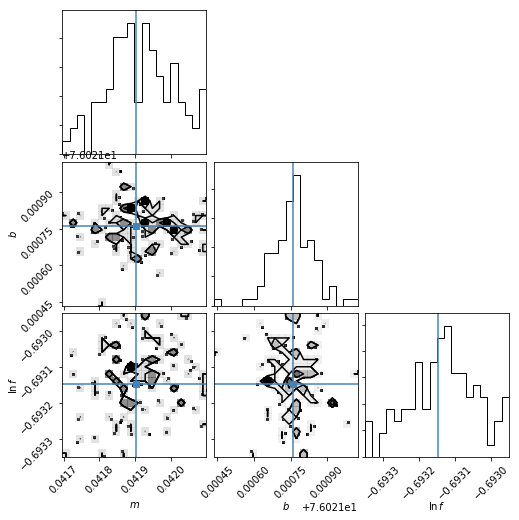

In [22]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_ls, b_ls, np.log(f_true)])
fig.savefig("triangle.png")

<ErrorbarContainer object of 3 artists>

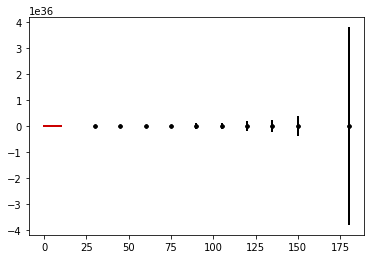

In [23]:
import matplotlib.pyplot as pl
xl = np.array([0, 10])

for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
    
pl.plot(xl, m_ls*xl+b_ls, color="r", lw=2, alpha=0.8)

pl.errorbar(x_new, y_new, yerr=paklaida, fmt=".k")

In [24]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(m_mcmc)
print(b_mcmc)
print(f_mcmc)

(0.04191370984393199, 9.210199177754619e-05, 8.63977887029313e-05)
(76.02176094823861, 7.672236627342954e-05, 8.643595869273213e-05)
(0.5000089897144997, 4.47750065212249e-05, 4.719048787332758e-05)


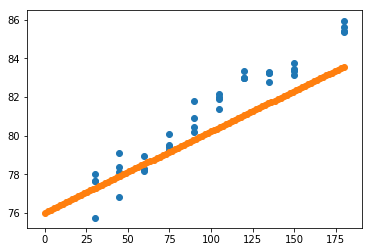

In [25]:
xs = np.linspace(0,180,100)
ys = m_mcmc[0]*xs + b_mcmc[0]
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)

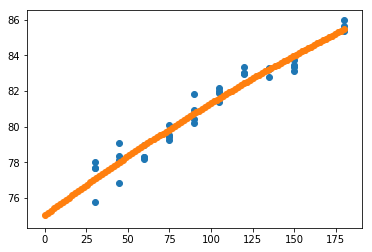

In [26]:
x_new, y_new
params = np.polyfit(x_new, y_new, 2)
xs = np.linspace(0,180,100)
ys = params[0]*xs**2 + params[1]*xs + params[2]
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)

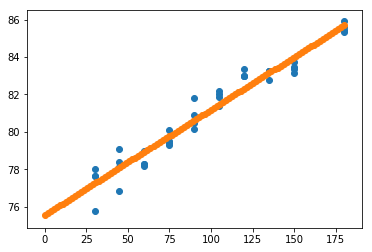

In [28]:
x_new, y_new
params = np.polyfit(x_new, y_new, 1)
xs = np.linspace(0,180,100)
ys = params[0]*xs + params[1]
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)

[  0  15  30  45  60  75  90 105 120 135 150 180] 
 
 [77.19988557 76.54805788 77.555633   78.38039374 78.47375848 79.61532433
 81.04042272 81.8996022  83.07906253 83.14847095 83.45257144 85.60963559] 
 
 [0.59449575 5.98246542 0.88975368 0.82613556 0.31430652 0.30627528
 0.62036944 0.30540438 0.15706869 0.19553547 0.22019108 0.2368001 ]


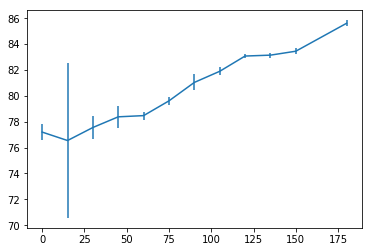

In [37]:
Ma = mtang.mean(axis=1)
Ms = mtang.std(axis=1,ddof=1)

anglen = angle[angle!=165] 

lnM = np.log(Ma)
lnMs = np.log(mtang).std(axis=1)
plt.errorbar(anglen, lnM, yerr=lnMs)
print(anglen,"\n","\n",  lnM,"\n","\n", lnMs)

(12, 2)
(12, 12)
[[ 7.67419108e-02 -5.75712651e-04]
 [-5.75712651e-04  4.74594293e-06]]


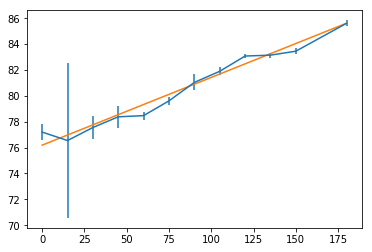

In [41]:
A = np.vstack((np.ones_like(anglen), anglen)).T
C = (lnMs * lnMs)*np.eye(len(lnMs), len(lnMs))
print(A.shape)
print(C.shape)

cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, lnM)))


xs = np.linspace(0,180,100)
ys = m_ls*xs + b_ls
plt.errorbar(anglen, lnM, yerr=lnMs)
plt.plot(xs, ys)
print(cov)

In [79]:
#import scipy.optimize as op
f_true = 0.9
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls, np.log(f_true)], args=(anglen, lnM, lnMs))
m_ml, b_ml, lnf_ml = result["x"]

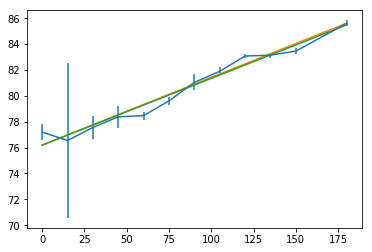

In [80]:

xs = np.linspace(0,180,100)
ys = m_ls*xs + b_ls
ym = m_ml*xs + b_ml

plt.errorbar(anglen, lnM, yerr=lnMs)
plt.plot(xs, ys)
plt.plot(xs, ym)

In [81]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(anglen, lnM, lnMs))
sampler.run_mcmc(pos, 500)

/home/s_matas/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/s_matas/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ 5.15872490e-02,  7.61953127e+01, -5.31193332e+00],
        [ 5.15809389e-02,  7.61953278e+01, -5.31215478e+00],
        [ 5.16082842e-02,  7.61953833e+01, -5.31205993e+00],
        [ 5.15404540e-02,  7.61952052e+01, -5.31227968e+00],
        [ 5.16321817e-02,  7.61951377e+01, -5.31208164e+00],
        [ 5.16134710e-02,  7.61951694e+01, -5.31217080e+00],
        [ 5.14986366e-02,  7.61951709e+01, -5.31224149e+00],
        [ 5.15853342e-02,  7.61952368e+01, -5.31201032e+00],
        [ 5.16947187e-02,  7.61952390e+01, -5.31205319e+00],
        [ 5.15613580e-02,  7.61953583e+01, -5.31220980e+00],
        [ 5.16967137e-02,  7.61951213e+01, -5.31231842e+00],
        [ 5.17643910e-02,  7.61953556e+01, -5.31232061e+00],
        [ 5.17236749e-02,  7.61953032e+01, -5.31220691e+00],
        [ 5.15267794e-02,  7.61952977e+01, -5.31225973e+00],
        [ 5.15862574e-02,  7.61953576e+01, -5.31223181e+00],
        [ 5.16841366e-02,  7.61952161e+01, -5.31201398e+00],
        [ 5.15472677e-02

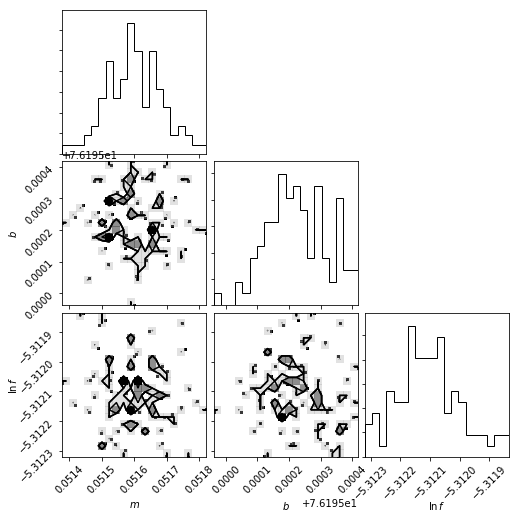

In [82]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_ls, b_ls, np.log(f_true)])
fig.savefig("triangle.png")

<ErrorbarContainer object of 3 artists>

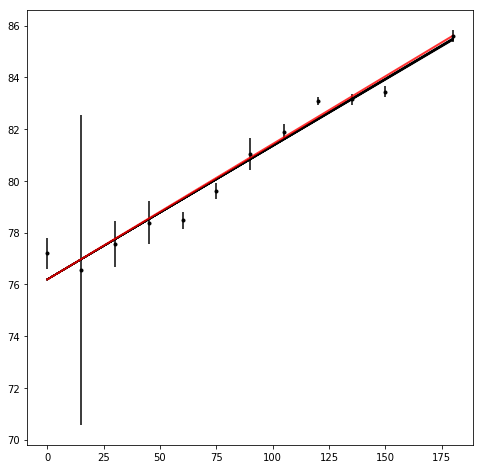

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
xl = np.array([0, 10])

xs = np.linspace(0,180,100)
ys = m_ls*xs + b_ls
ym = m_ml*xs + b_ml

#plt.errorbar(anglen, lnM, yerr=lnMs)
#plt.plot(xs, ys)
#plt.plot(xs, ym)

for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xs, m*xs + b, color="k", alpha=0.1)
    
plt.plot(xs, m_ls*xs + b_ls, color="r", lw=2, alpha=0.8)

plt.errorbar(anglen, lnM, yerr=lnMs, fmt=".k")

(0.051598881617707586, 8.375754606054081e-05, 7.780762862719809e-05)
(76.19521877819443, 0.00011011817028361293, 7.814735953104446e-05)
(0.004931515505483796, 4.994113698376587e-07, 5.068980358452838e-07)


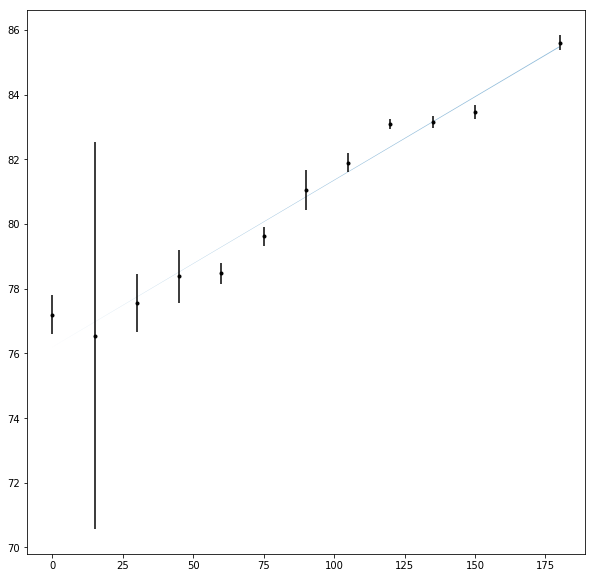

In [84]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(m_mcmc)
print(b_mcmc)
print(f_mcmc)
plt.figure(figsize=(10,10))

plt.errorbar(anglen, lnM, yerr=lnMs, fmt=".k")
#plt.plot(xs, xs*m_mcmc[0] + b_mcmc[0])

plt.fill_between(xs, xs*(m_mcmc[0]+m_mcmc[1])+ b_mcmc[0]+b_mcmc[1], xs*(m_mcmc[0]-m_mcmc[1])+ b_mcmc[0]-b_mcmc[1], alpha= 0.5)